# **Brain Tumor Segmentation using UNet**
The Goal of this to develop a Deep Learning model based on UNet for generating the Segmentations for the given MRI scans. The model will be able to train on the train data provided which consists of MRI scans along with Segmentation images. Later the model will be able to identify the segmentation parts from the scan images provided to it. For implementing this project, we will be using state of the art UNet architecture, a convolutional neural network developed to yield more precise segmentations. 



**Steps involved in this project are:**
1. Importing necessary packages
2. Data Loading and Pre-processing
3. Creating a Custom Data Generator
4. Building the Model
5. Compiling the Model
6. Training the Model
7. Plotting the Results
8. Predicting on new Data

Let's start implementing these steps one by one in a detailed manner.

## **1. Importing necessary Packages**

In [1]:
import time
from tqdm import tqdm
import os
import time
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import CSVLogger
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Model, load_model
from keras.utils.vis_utils import plot_model

from skimage.transform import resize
from skimage import exposure
import cv2 as cv

## **Download the Dataset**
Connect to Google Drive to download the Dataset and create Training and Testing Datasets. 

 - We will connect to Google Drive
 - Create 'Training' and 'Testing ' directories in colab environment
 - Extract the Datasets accordingly

In [2]:
# Connect to Google Drive
from google.colab import drive
from google.colab import files
drive.mount("/content/MyDrive", force_remount = True)

Mounted at /content/MyDrive


In [3]:
# Create the directories for loading Training and Validation Data
%cd /content/
try:
  os.mkdir("Training")
except Exception as e:
  print(e)

try:
  os.mkdir("Testing")
except Exception as e:
  print(e)

/content


Change the 'PROJECT_PATH', 'TRAIN_DATASET_PATH', and 'TEST_DATASET_PATH' variable to desired location where all our project files are saved.

In [4]:
# Declaring the PATH variables required 
PROJECT_PATH = "/content/MyDrive/MyDrive/Colab_Notebooks/BrainTumour"
TRAIN_DATASET_PATH = "/content/Training"
TEST_DATASET_PATH = "/content/Testing"

In [5]:
# Extract the Training and validation data 
from zipfile import ZipFile
def extract_train_data_from_zipfiles():
  print("Extracting Training data files...")
  train_zip_file = ZipFile("/content/MyDrive/MyDrive/Colab_Notebooks/BrainTumour/BraTS2020_TrainingData.zip", "r")
  train_zip_file.extractall(path = TRAIN_DATASET_PATH)
  train_zip_file.close()
  print("Training Data Extraction Completed.")

def extract_test_data_from_zipfiles():
  print("Extracting Testing data files...")
  test_zip_file = ZipFile("/content/MyDrive/MyDrive/Colab_Notebooks/BrainTumour/BraTS2020_ValidationData.zip", "r")
  test_zip_file.extractall(path = TEST_DATASET_PATH)
  print("Testing Data Extraction Completed.") 
  test_zip_file.close()

extract_train_data_from_zipfiles()
#extract_test_data_from_zipfiles()

Extracting Training data files...
Training Data Extraction Completed.


## **2. Data Loading and Pre-processing**
All the images in the dataset are in '.nii' format. So we will write a custom method for reading the medical images using 'nibabel' library and convert them into an numpy array for further processing. As these medical images are in 3D shape, we will have to read them in an array for utilizing them in Data Generation process.





#### **Write a Function for reading the image**

In [6]:
# Reading a .nii file and returning its array
def read_image(path):
    image = nib.load(path)
    image = image.get_fdata()
    return np.asarray(image)

#### **Read images of one case and plot them**
There are a variety of semi-automatic and automated approaches and procedures for Segmentation of Brain Tumor in Medical field. They are T1-weighted (TI) and T1-weighted contrast-enhanced (T1ce), T2-weighted and T2-weighted Fluid Attenuated Inversion Recovery (FLAIR) techniques. The Dataset contains a single folder of all these MRI images of a patient along with the Mask or Segment image. 

Text(0.5, 1.0, 'Mask')

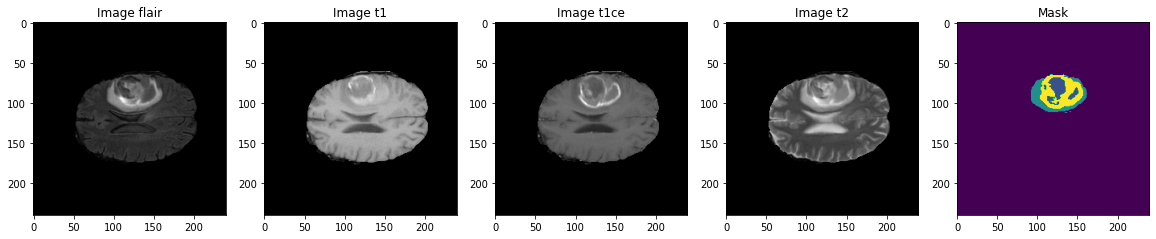

In [7]:
# Visualize any one of the training Images
# Give the patient id below to inspect the MRIs of the patient
patient_id = "187"

# Loading all the 5 MRI Images
read_flair = read_image(os.path.join(TRAIN_DATASET_PATH, 
    f"MICCAI_BraTS2020_TrainingData/BraTS20_Training_{patient_id}/BraTS20_Training_{patient_id}_flair.nii"))
read_t1 = read_image(os.path.join(TRAIN_DATASET_PATH, 
    f"MICCAI_BraTS2020_TrainingData/BraTS20_Training_{patient_id}/BraTS20_Training_{patient_id}_t1.nii"))
read_t1ce = read_image(os.path.join(TRAIN_DATASET_PATH, 
    f"MICCAI_BraTS2020_TrainingData/BraTS20_Training_{patient_id}/BraTS20_Training_{patient_id}_t1ce.nii"))
read_t2 = read_image(os.path.join(TRAIN_DATASET_PATH, 
    f"MICCAI_BraTS2020_TrainingData/BraTS20_Training_{patient_id}/BraTS20_Training_{patient_id}_t2.nii"))
read_mask = read_image(os.path.join(TRAIN_DATASET_PATH, 
    f"MICCAI_BraTS2020_TrainingData/BraTS20_Training_{patient_id}/BraTS20_Training_{patient_id}_seg.nii"))

# Plotting the 5 Images
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (20, 10))
slice_w = 25
ax1.imshow(read_flair[:, :, read_flair.shape[0] // 2 - slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(read_t1[:, :, read_t1.shape[0] // 2 - slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(read_t1ce[:, :, read_t1ce.shape[0] // 2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(read_t2[:, :, read_t2.shape[0] // 2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(read_mask[:, :, read_mask.shape[0] // 2-slice_w])
ax5.set_title('Mask')


## **3. Creating a Custom Data Generator**

The Dataset the we are currently working consumes a lot of memory as these are the high resolution medical images (MRI) in spatial format.  So for processing these images, sometimes even the most state-of-the-art configuration won't have enough memory space to process the data the way we used to do it. To overcome this, we are going to generate our dataset on multiple cores in real time and feed it right away to our deep learning model while training itself. The framework used here is the one provided by Python's high-level package Keras, which can be used on top of a GPU installation of either TensorFlow or Theano. We will set up the Python class DataGenerator, which will be used for real-time data feeding to our Keras model. Further details are provided along with the code about the Data Generation. And remember that here we train the middle 100 slice of each volume per epoch. So, Batch size = 1 means batch size = 100 slices.

In [8]:
# Initializing the function of the class, so that it inherit the properties of 
#   keras.utils.Sequence to leverage functionalities such as multiprocessing.
NO_OF_SLICES = 100
SLICE = 24
IMG_SIZE = 128

# Create Custom Data Generator Class
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, patient_IDs, dimension = (IMG_SIZE, IMG_SIZE), batch_size = 1, n_channels = 2, shuffle = True):
        self.dimension = dimension
        self.batch_size = batch_size
        self.list_of_IDs = patient_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    # Method to decide the number of batches per epoch
    def __len__(self):
        return int(np.floor(len(self.list_of_IDs) / self.batch_size))

    # Method to generate one batch of data at a time
    def __getitem__(self, index):        
        # Generate indices of the batch
        indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        generated_batch_IDs = [self.list_of_IDs[i] for i in indices]
        # Generate data
        X, y = self.__data_generation(generated_batch_IDs)
        return X, y

    # Method to update indices after each epoch
    def on_epoch_end(self):        
        self.indices = np.arange(len(self.list_of_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    # Method to generate data containing batch_size samples
    def __data_generation(self, generated_batch_IDs):
        # Initialization
        X = np.zeros((self.batch_size * NO_OF_SLICES, *self.dimension, self.n_channels))
        y = np.zeros((self.batch_size * NO_OF_SLICES, 240, 240))
        Y = np.zeros((self.batch_size * NO_OF_SLICES, *self.dimension, 4))
        
        # Generate data
        for c, i in enumerate(generated_batch_IDs):
            patient_mri_path = os.path.join(TRAIN_DIR_PATH, i)

            flair_vol_path = os.path.join(patient_mri_path, f"{i}_flair.nii")
            flair = read_image(flair_vol_path)      
            ce_vol_path = os.path.join(patient_mri_path, f"{i}_t1ce.nii")
            ce = read_image(ce_vol_path)            
            seg_vol_path = os.path.join(patient_mri_path, f"{i}_seg.nii")
            seg = read_image(seg_vol_path)
        
            for j in range(NO_OF_SLICES):
                 X[j + NO_OF_SLICES * c, :, :, 0] = cv.resize(flair[:, :, j + SLICE], (IMG_SIZE, IMG_SIZE))
                 X[j + NO_OF_SLICES * c, :, :, 1] = cv.resize(ce[:, :, j + SLICE], (IMG_SIZE, IMG_SIZE))
                 y[j + NO_OF_SLICES * c] = seg[:, :, j + SLICE]
                    
        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (128, 128))
        return X/np.max(X), Y

In [9]:
# Prepare Case IDs of Train and Validation for giving to DataGenerator
TRAIN_DIR_PATH = '/content/Training/MICCAI_BraTS2020_TrainingData'
TEST_DIR_PATH = "/content/Testing/MICCAI_BraTS2020_ValidationData"

train_IDs = next(os.walk(TRAIN_DIR_PATH, topdown=True))[1][:350]
val_IDs = next(os.walk(TRAIN_DIR_PATH, topdown=True))[1][350:370]
#test_IDs = next(os.walk(TESTING_DIR_PATH))

# Delete the files related to Case ID 355
if ('BraTS20_Training_355' in val_IDs):
  val_IDs.remove('BraTS20_Training_355')
  print("'BraTS20_Training_355' removed from val_IDs.")
elif ('BraTS20_Training_355' in train_IDs):
  train_IDs.remove('BraTS20_Training_355')
  print("'BraTS20_Training_355' removed from train_IDs.")
else:
  print("'BraTS20_Training_355' is already removed.")

# Calling the DataGenerator class on case IDs
training_generator = DataGenerator(train_IDs)
valid_generator = DataGenerator(val_IDs)
#test_generator = DataGenerator(test_IDs)

'BraTS20_Training_355' removed from train_IDs.


### **Evaluation Metrics**

There are different kinds of Evaluation metrics for Segmentation Models. The widely used metrics are Pixel Accuracy, Intersection-Over-Union (Jaccard Index), and Dice Coefficient (F1 Score). Among all these we are going to use Dice Coefficeint. 

**Dice Coefficient:** Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images. <br><br>
![img](https://miro.medium.com/max/429/1*yUd5ckecHjWZf6hGrdlwzA.png)


#### **Mean Intersection over Union (MeanIoU)**

Mean Intersection-Over-Union is a common evaluation metric for semantic image segmentation, which first computes the IOU for each semantic class and then computes the average over classes. IOU is defined as follows: 
<br>
`IOU = true_positive / (true_positive + false_positive + false_negative)`. 

The predictions are accumulated in a confusion matrix, weighted by sample_weight and the metric is then calculated from it.


In [10]:
# Method to Calculate Dice Coefficient
def calc_dice_coef(y_true, y_pred, smooth = 1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:, :, :, i])
        y_pred_f = K.flatten(y_pred[:, :, :, i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

# Method to Calculate Dice Coefficient Loss
def dice_coef_loss(y_true, y_pred):
    return 1 - calc_dice_coef(y_true, y_pred)

## **4. Building the Model**
For Biomedical Image Segmentation, we are going to use U-Net architecture, a convolutional neural network that was developed for the purpose at the Computer Science Department of the University of Freiburg. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations. The main idea is to supplement a usual contracting network by successive layers, where pooling operations are replaced by upsampling operators. Hence these layers increase the resolution of the output. What's more, a successive convolutional layer can then learn to assemble a precise output based on this information.
One important modification in U-Net is that there are a large number of feature channels in the upsampling part, which allow the network to propagate context information to higher resolution layers. As a consequence, the expansive path is more or less symmetric to the contracting part, and yields a u-shaped architecture. To predict the pixels in the border region of the image, the missing context is extrapolated by mirroring the input image. 
The network consists of a contracting path and an expansive path, which gives it the u-shaped architecture. The contracting path is a typical convolutional network that consists of repeated application of convolutions, each followed by a rectified linear unit (ReLU) and a max pooling operation. During the contraction, the spatial information is reduced while feature information is increased. The expansive pathway combines the feature and spatial information through a sequence of up-convolutions and concatenations with high-resolution features from the contracting path.

In [11]:
# Build U-Net model
def unet(dropout, hn, activation_fn = 'relu', padding = 'same'):
    
    inputs = Input((IMG_SIZE, IMG_SIZE, 2)) 
    
    conv1 = Conv2D(32, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(inputs)
    conv1 = Conv2D(32, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(pool)
    conv = Conv2D(64, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(pool1)
    conv2 = Conv2D(128, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(pool2)
    conv3 = Conv2D(256, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(conv3)    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(pool4)
    conv5 = Conv2D(512, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Upsampling
    up7 = Conv2D(256, 2, activation = activation_fn, padding = padding, kernel_initializer = hn)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(merge7)
    conv7 = Conv2D(256, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(conv7)

    up8 = Conv2D(128, 2, activation = activation_fn, padding = padding, kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(merge8)
    conv8 = Conv2D(128, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(conv8)

    up9 = Conv2D(64, 2, activation = activation_fn, padding = padding, kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(merge9)
    conv9 = Conv2D(64, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(conv9)
    
    up = Conv2D(32, 2, activation = activation_fn, padding = padding, kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(merge)
    conv = Conv2D(32, 3, activation = activation_fn, padding = padding, kernel_initializer = hn)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    model = Model(inputs = inputs, outputs = conv10)

    return model

K.clear_session()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

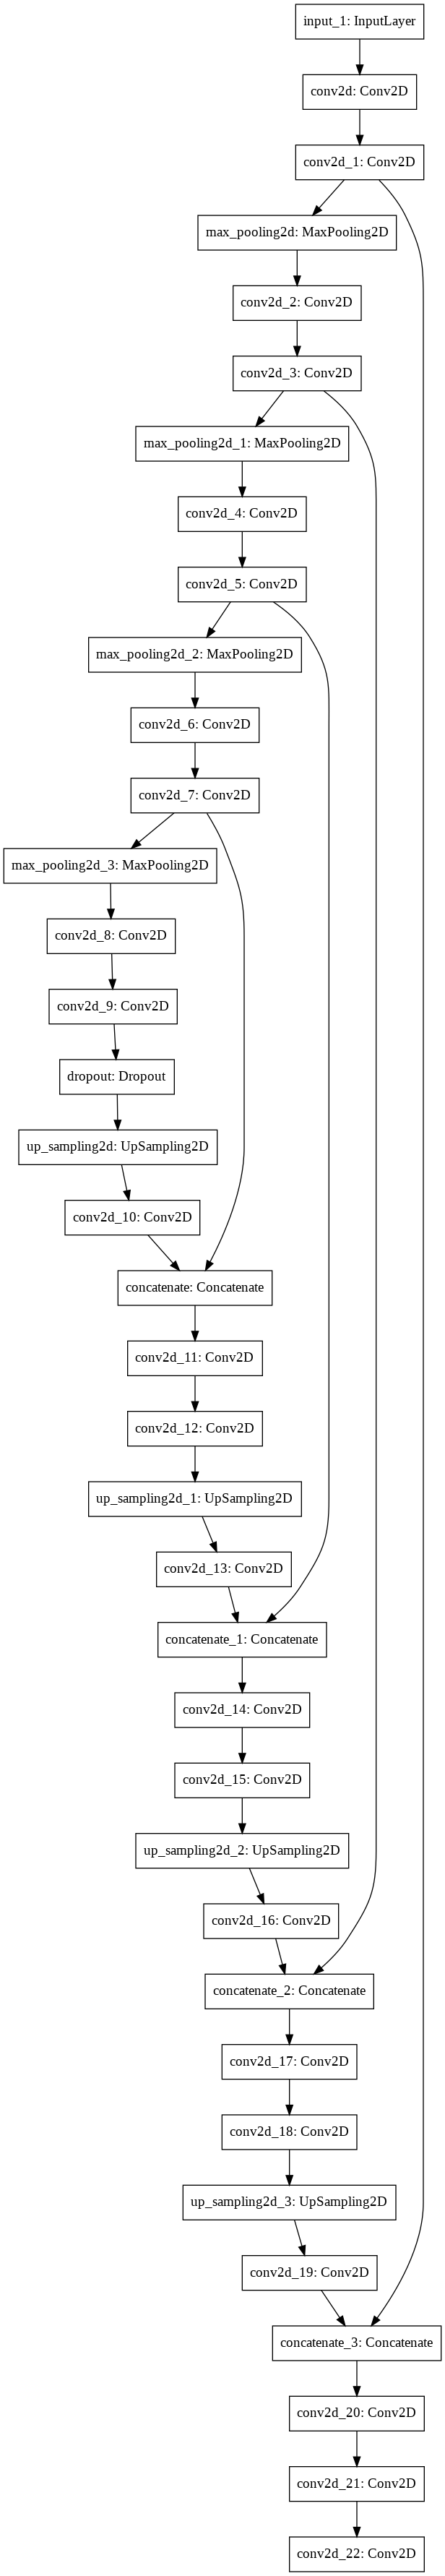

In [12]:
# Calling the model with relevant parameters
model = unet(
    dropout = 0.2, 
    hn = 'he_normal', 
    activation_fn = 'relu', 
    padding = 'same'
)

# Printing the summary of the model
model.summary()

plot_model(model, to_file='model.png')
#files.download("/content/model.png")

In [13]:
# Adding model Check points and saving the training log file along with weights file
callbacks = [
             ModelCheckpoint("best_model.h5", verbose = 1, save_best_model = True),
             ReduceLROnPlateau(monitor = "val_loss", patience = 2, factor = 0.1, verbose = 1, min_lr = 1e-6),
             EarlyStopping(monitor = "loss", patience = 3, verbose = 1)
]

## **5. Compiling the Model**
We will compile the model using `Adam` optimizer with loss function as `categorial crossentropy` with accuracy and dice coeffecient as metrics.

In [14]:
# Compile the Model
model.compile(
    optimizer = keras.optimizers.Adam(), 
    loss = "categorical_crossentropy", 
    metrics = ["accuracy", tf.keras.metrics.MeanIoU(num_classes = 4), calc_dice_coef]
) 


## **6. Training the Model**
With all the setup is completed, finally it is time for training our model. We will train our model using training and validation generators for at least 40 epoch to gain a minimum accuracy of 99.5%. As we have added check points the model will automatically save the best model after the end of an epoch.

In [ ]:
# Train the Model
EPOCHS = 50
STEPS_PER_EPOCH = len(train_IDs)

results = model.fit(
    training_generator,
    epochs = EPOCHS,
    steps_per_epoch = STEPS_PER_EPOCH,  
    validation_data = valid_generator,
    callbacks = callbacks
)  

Epoch 1/50
349/349 [==============================] - 259s 677ms/step - loss: 0.1122 - accuracy: 0.9827 - mean_io_u: 0.6235 - calc_dice_coef: 0.2670 - val_loss: 0.0614 - val_accuracy: 0.9846 - val_mean_io_u: 0.6756 - val_calc_dice_coef: 0.2923

Epoch 00001: saving model to best_model.h5
Epoch 2/50
344/349 [============================>.] - ETA: 3s - loss: 0.0724 - accuracy: 0.9831 - mean_io_u: 0.5705 - calc_dice_coef: 0.2792

## **7. Plotting the Results**
As the Model training is completed, let's visualize the model performance in terms of Accuracy, Loss and Dice Loss to understand how well the model is working.

#### **Accuracy**

In [ ]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25, wspace=0.35)
plt.savefig("Model_Accuracy.png", dpi = 100, bbox_inches='tight')
plt.show()

#### **Model Loss**

In [ ]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.savefig("Model_Loss.png", dpi = 100, bbox_inches='tight')
plt.show()

#### **Dice Coeffecient Loss**

In [ ]:
plt.plot(results.history['calc_dice_coef'])
plt.plot(results.history['val_calc_dice_coef'])
plt.title('Model Dice Loss')
plt.ylabel('Dice_Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.savefig("Model_Dice_Loss.png", dpi = 100, bbox_inches='tight')
plt.show()

#### **Mean Intersection over Union (MeanIoU)**

In [ ]:
plt.plot(results.history['mean_io_u_1'])
plt.plot(results.history['val_mean_io_u_1'])
plt.title('Mean Intersection over Union')
plt.ylabel('MeanIoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.savefig("Model_MeanIoU.png", dpi = 100, bbox_inches='tight')
plt.show()

In [ ]:
# Download graphs and model file to GDrive and Local Machine
files.download("best_model.h5")
files.download("Model_Loss.png")
files.download("Model_Dice_Loss.png")
files.download("Model_Accuracy.png")
files.download("Model_MeanIoU.png")
!cp "/content/best_model.h5" $PROJECT_PATH
!cp "/content/Model_Loss.png" $PROJECT_PATH
!cp "/content/Model_Dice_Loss.png" $PROJECT_PATH
!cp "/content/Model_Accuracy.png" $PROJECT_PATH
!cp "/content/Model_MeanIoU.png" $PROJECT_PATH

## **8. Predicting on new Data**
Now all the steps are completed, we will generate some predictions on the test data. For comparision purpose we will be using the training data and later we can also use new images for getting the segmentation part.

In [ ]:
# Load the saved model
SAVED_MODEL_PATH = os.path.join(PROJECT_PATH, "best_model_Project-1.h5")
model = keras.models.load_model(SAVED_MODEL_PATH, compile = False)
os.mkdir("/content/Results")

In [ ]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'Not Tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE = 128

# Get the predictions by path of given patient id
def predictByPath(case_path, case):
    print(case)
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=read_image(vol_path);
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=read_image(vol_path);   
    
    for j in range(VOLUME_SLICES):
         X[j,:,:,0] = cv.resize(flair[:,:,j+22], (IMG_SIZE,IMG_SIZE))
         X[j,:,:,1] = cv.resize(ce[:,:,j+22], (IMG_SIZE,IMG_SIZE))
    return model.predict(X/np.max(X), verbose=1)

In [ ]:
# Show/Plot the predictions given by case id
def showPredictsById(case, start_slice = VOLUME_START_AT):
    path = f"/content/Training/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path, case)

    core = p[:,:,:,1]
    edema = p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure()
    fig1, axarr = plt.subplots(1,3, figsize = (25, 75))
    fig1.tight_layout()
    
    axarr[0].imshow(cv.resize(origImage[:,:,start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original Flair')
    curr_gt=cv.resize(gt[:,:,start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="gray", interpolation='none') # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4])
    axarr[2].title.set_text('Predicted')    

    FILENAME_HERE = f"Case ID:{case}_Prediction_1.png"
    plt.savefig(os.path.join("/content/Results", FILENAME_HERE), dpi = 120)
    #files.download("Results" + "/" +FILENAME_HERE)

    plt.show()

In [ ]:
# Randomly selecting two case ids for predicting
import random
for i in range(2):
  showPredictsById(random.randint(100, 350))